# Εργασία 2: Αυτόματη διάγνωση σε ιατρικές εικόνες

Πέρα από τα εργαστήρια 2a και 2b, μπορείτε να βρείτε έτοιμο σχετικό κώδικα και εδώ:

https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

Εγκαθιστούμε τη βιβλιοθήκη `medmnist` στο virtual machine μας. (Χρειάζεται μόνο την πρώτη φορά κάθε session).

In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 4.8 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=a1a02282fc40f888ee0fb19594d9a0c19c05918714d91ce100554490adda6971
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


## Εισαγωγή αναγκαίων βιβλιοθηκών και πακέτων
Μπορείτε να επεκτείνετε αυτόν τον κώδικα με ό,τι χρειάζεστε

In [ ]:
from tqdm import tqdm

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.optim import lr_scheduler

import medmnist
from medmnist import INFO
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

print("Pytorch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

Pytorch version: 1.11.0+cu113
GPU available: True
MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


## Transforms
Θα χρησιμοποιήσουμε τις ίδιες προεπεξεργασίες για όλα τα δεδομένα μας ώστε τα διαφορετικά μοντέλα να είναι συμβατά μεταξύ τους.

Αυτό στηρίζεται στο ότι οι εικόνες των datasets που θα χρησιμοποιήσουμε θα έχουν ίσες διαστάσεις μεταξύ τους (28$\times$28$\times$3)

In [ ]:
#Random Horizontal flipping has a default value of 0.5
#Maybe will need a change afterwards?

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5]),
        transforms.RandomHorizontalFlip()
    ]),
    
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ]),
}

## Εισαγωγή του Colon Pathology dataset 

In [ ]:
# Το αντικείμενο medmnist.INFO μανατζάρει όλα τα datasets του medmnist. Με το κλειδί 'pathmnist' (το βρήκαμε στο documentation) επιλέγουμε το Colon Pathology Dataset
path_info = INFO['pathmnist']
path_task = path_info['task']
path_channels = path_info['n_channels']
path_classes = len(path_info['label'])

print ("Οι εικόνες του dataset έχoυν", path_channels, "κανάλια. Ο τύπος προβλήματος είναι", path_task, "ταξινόμηση με", path_classes, "κλάσεις.")

Οι εικόνες του dataset έχoυν 3 κανάλια. Ο τύπος προβλήματος είναι multi-class ταξινόμηση με 9 κλάσεις.


  0%|          | 0/205615438 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
---------------------------------------------------------------------
Διαθέσιμες πληροφορίες για το dataset:
dict_keys(['python_class', 'description', 'url', 'MD5', 'task', 'label', 'n_channels', 'n_samples', 'license'])
Περιγραφή dataset:
The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Ερμηνεία labels:
{'0'

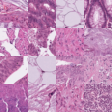

In [ ]:
# Το πεδίο 'python_class' του info επιστρέφει μια κλάση της python που λειτουργεί ως pytorch dataset, για να την περάσουμε στο dataloader
Path_DataClass = getattr(medmnist, path_info['python_class'])

# Φόρτωση (και κατέβασμα) δεδομένων
path_train_dataset = Path_DataClass(split='train', transform=data_transforms['train'], download=True)
path_val_dataset = Path_DataClass(split='val', transform=data_transforms['test'], download=True)
path_test_dataset = Path_DataClass(split='test', transform=data_transforms['test'], download=True)

#Το .info είναι ένα dictionary με επεξηγηματικές πληροφορίες για το dataset
print("---------------------------------------------------------------------")
print("Διαθέσιμες πληροφορίες για το dataset:")
print(path_train_dataset.info.keys())
print("Περιγραφή dataset:")
print(path_train_dataset.info['description'])
print("Ερμηνεία labels:")
print(path_train_dataset.info['label'])

BATCH_SIZE = 256

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=path_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=path_val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=path_val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


print("Δείγμα εικόνων του Colon Pathology dataset:")
path_train_dataset.montage(length=4)

## Δημιουργία μοντέλου

Ο ενδεικτικός κώδικας του MedMNIST προβλέπει τόσο ο αριθμός των καναλιών των εικόνων όσο και ο αριθμός των κλάσεων να εισάγονται ως παράμετροι. Αυτή η ευελιξία δεν μας είναι απαραίτητη καθώς εμείς θα δημιουργήσουμε ένα δίκτυο που θα δέχεται εικόνες 3 καναλιών και θα επιστρέφει 9 κλάσεις, συγκεκριμένα για το PathMNIST. Οποιαδήποτε αλλαγή κάνουμε (π.χ. στον αριθμό των κλάσεων/μονάδων εξόδου) θα γίνει αφού δημιουργήσουμε ένα στιγμιότυπο του ίδιου δικτύου.

Παρόλα αυτά, αν προτιμάτε να τα αφήσετε ως παραμέτρους, μπορείτε.

In [ ]:
class Net(nn.Module):
  def __init__(self, num_classes):
    super().__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size =  3, padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size =  3, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU()
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size =  6, padding = 2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.layer4 = nn.Sequential(
        nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size =  3, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.layer5 = nn.Sequential(
        nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size =  3, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
    )

    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(576, 1024),
        nn.Linear(1024, num_classes)
    )
    

  def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.layer5(x)
      x = self.fc(x)
      return x
  

##4. Αξιοποίηση CUDA 

In [ ]:
net = Net(path_classes)
device = torch.device('cuda')

#wraping the model in nn.DataParallel to support data parallel training on multiple GPUs
#if torch.cuda.device_count() > 1:
#  print("Let's use", torch.cuda.device_count(), "GPUs!")
#  net = nn.DataParallel(net)
net.to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


##5. Παραμετροποίηση

In [ ]:
learning_rate = 0.005
optimizer = optim.SGD(net.parameters(), learning_rate, momentum = 0.9)
scheduler = lr_scheduler.StepLR(optimizer,step_size = 3, gamma = 0.5)
criterion = nn.CrossEntropyLoss()
Batch_size = 128
epochs = 9

##6. Training και Test Loop

In [ ]:
#Test
def test(split):

    net.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    y_true, y_score = y_true.to(device), y_score.to(device)
    
    data_loader = train_loader if split == 'train' else test_loader if split == 'test' else val_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)


            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.cpu().detach().numpy()
        

        accuracy = accuracy_score(y_true, np.argmax(y_score, axis = 1))
    
        print('%s  acc:%5.3f' % (split, accuracy))


#Train
def train_model():
    for epoch in range(epochs):
    
        net.train()
        running_loss = 0.0
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
            loss.backward()
            optimizer.step()

            #statistics
            running_loss += loss.item() * inputs.size(0)
            #running_corrects += torch.sum(preds == labels.data)
       

        scheduler.step()

        #loss of every training epoch  
        epoch_loss = running_loss / Batch_size
        print(f'[{epoch + 1}] loss:' , {epoch_loss})

        #train function στο τελος καθε epoch 
        test('train')
        test('validation')

train_model()

print('==> Evaluating ...')
test('train')
test('test')

100%|██████████| 352/352 [00:30<00:00, 11.43it/s]


[1] loss: {271.5262390533462}
train  acc:0.839
validation  acc:0.845


100%|██████████| 352/352 [00:34<00:00, 10.16it/s]


[2] loss: {194.96536159748212}
train  acc:0.768
validation  acc:0.767


100%|██████████| 352/352 [00:30<00:00, 11.39it/s]


[3] loss: {157.52950373198837}
train  acc:0.889
validation  acc:0.886


100%|██████████| 352/352 [00:31<00:00, 11.23it/s]


[4] loss: {115.62311732815579}
train  acc:0.938
validation  acc:0.934


100%|██████████| 352/352 [00:30<00:00, 11.37it/s]


[5] loss: {103.16050266008824}
train  acc:0.929
validation  acc:0.925


100%|██████████| 352/352 [00:31<00:00, 11.24it/s]


[6] loss: {93.07227436453104}
train  acc:0.927
validation  acc:0.922


100%|██████████| 352/352 [00:30<00:00, 11.36it/s]


[7] loss: {75.24776589428075}
train  acc:0.967
validation  acc:0.957


100%|██████████| 352/352 [00:30<00:00, 11.43it/s]


[8] loss: {70.99686291348189}
train  acc:0.964
validation  acc:0.955


100%|██████████| 352/352 [00:30<00:00, 11.49it/s]


[9] loss: {67.16833026474342}
train  acc:0.959
validation  acc:0.949
==> Evaluating ...
train  acc:0.960
test  acc:0.949


Χρησιμοποιώ accuracy γνωρίζοντας οτι έχω πολλές ίσου πλήθους κλάσεις. Στο ενδεχόμενο που δεν ίσχυε αυτό μια καλύτερη μετρική θα μπορούσε να αποτελέσει το F-Μeasure 

Το μοντέλο απο όσο φαίνεται δείχνει σοβαρά σημάδια overfitting. Το train acc είναι ελαφρώς μεγαλύτερο απο το test acc. Το δίκτυο παρόλα αυτά μαθαίνει με ένα μικρό (αλλά σχεδόν σταθερό ρυθμό) 

## Εισαγωγή του Blood Cell Microscope dataset 

In [ ]:
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
print (task)
blood_channels = info['n_channels'] # αν τα κανάλια στα inputs είναι διαφορετικά, το transfer learning δεν έχει νόημα γιατί τα δεδομένα δε θα έχουν καμία ομοιότητα
blood_classes = len(info['label'])

Blood_Dataclass = getattr(medmnist, info['python_class'])

multi-class


  0%|          | 0/35461855 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
{'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'task': 'multi-class', 'label': {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '

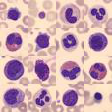

In [ ]:
# load the data
blood_train_dataset = Blood_Dataclass(split='train', transform=data_transforms['train'], download=download)
blood_val_dataset = Blood_Dataclass(split='val', transform=data_transforms['test'], download=download)
blood_test_dataset = Blood_Dataclass(split='test', transform=data_transforms['test'], download=download)
print(blood_test_dataset.info)


# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=blood_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=blood_val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=blood_test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

print("Δείγμα εικόνων του Blood Cell Microscope dataset:")
blood_train_dataset.montage(length=4)

##8. Εκπαίδευση με Transfer Learning στο BloodMNIST dataset

In [ ]:
#Αντιγράφω το δίκτυο στον δίσκο για χρήση του κατά το transfer learning 
FILENAME = './path_net.pth'
torch.save(net.state_dict(), 'path_net.pth')

In [ ]:
import copy

#Δημιουργία νέου instance 
netBlood = Net(path_classes)

#Αντιγραφή βαρών
netBlood.load_state_dict(torch.load(FILENAME))

#Εκπαίδευση με πάγωμα βαρών
for param in netBlood.parameters():
    param.requires_grad = False


netBlood.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(576, 1024),
        nn.Linear(1024, blood_classes)
    )

#GPU
netBlood.to(device)

#νέοι optimizer/scheduler 
optimizer_Tranferblood = optim.SGD(netBlood.parameters(), learning_rate, momentum = 0.9)
scheduler_Tranferblood = lr_scheduler.StepLR(optimizer_Tranferblood,step_size = 2, gamma = 0.5)

train_model()

print('==> Evaluating ...')
test('train')
test('test')

100%|██████████| 47/47 [00:04<00:00, 10.90it/s]


[1] loss: {22.89815902430564}
train  acc:0.917
validation  acc:0.908


100%|██████████| 47/47 [00:04<00:00, 10.81it/s]


[2] loss: {22.80653464968782}
train  acc:0.917
validation  acc:0.908


100%|██████████| 47/47 [00:04<00:00, 10.97it/s]


[3] loss: {23.19890213420149}
train  acc:0.915
validation  acc:0.910


100%|██████████| 47/47 [00:04<00:00, 11.13it/s]


[4] loss: {22.83326291211415}
train  acc:0.918
validation  acc:0.911


100%|██████████| 47/47 [00:04<00:00, 11.06it/s]


[5] loss: {22.885770390043035}
train  acc:0.917
validation  acc:0.908


100%|██████████| 47/47 [00:04<00:00, 11.03it/s]


[6] loss: {23.109306173864752}
train  acc:0.919
validation  acc:0.909


100%|██████████| 47/47 [00:04<00:00, 10.99it/s]


[7] loss: {23.019483124720864}
train  acc:0.918
validation  acc:0.911


100%|██████████| 47/47 [00:04<00:00, 11.07it/s]


[8] loss: {22.90303609217517}
train  acc:0.917
validation  acc:0.909


100%|██████████| 47/47 [00:04<00:00, 10.63it/s]


[9] loss: {22.874338398920372}
train  acc:0.920
validation  acc:0.909
==> Evaluating ...
train  acc:0.918
test  acc:0.904


##9. Εκπαίδευση χωρίς Transfer Learning στο BloodMNIST dataset

In [ ]:
#Δημιουργία 3ου instance
netBloodNoTransfer = Net(blood_classes)

netBloodNoTransfer.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(576, 1024),
        nn.Linear(1024, blood_classes)
    )

#GPU
netBloodNoTransfer.to(device)

#νέοι optimizer/scheduler 
optimizer_NoTranferblood = optim.SGD(netBloodNoTransfer.parameters(), learning_rate, momentum = 0.9)
scheduler_NoTranferblood = lr_scheduler.StepLR(optimizer_NoTranferblood,step_size = 2, gamma = 0.5)

train_model()

print('==> Evaluating ...')
test('train')
test('test')

100%|██████████| 47/47 [00:04<00:00, 10.91it/s]


[1] loss: {23.056629144237377}
train  acc:0.917
validation  acc:0.911


100%|██████████| 47/47 [00:04<00:00,  9.57it/s]


[2] loss: {22.634749794728123}
train  acc:0.918
validation  acc:0.910


100%|██████████| 47/47 [00:04<00:00, 11.05it/s]


[3] loss: {22.66711104218848}
train  acc:0.918
validation  acc:0.908


100%|██████████| 47/47 [00:04<00:00, 10.66it/s]


[4] loss: {22.786523832473904}
train  acc:0.918
validation  acc:0.909


100%|██████████| 47/47 [00:04<00:00, 10.82it/s]


[5] loss: {22.97025026148185}
train  acc:0.918
validation  acc:0.910


100%|██████████| 47/47 [00:04<00:00, 11.11it/s]


[6] loss: {22.88106160191819}
train  acc:0.915
validation  acc:0.910


100%|██████████| 47/47 [00:04<00:00, 11.10it/s]


[7] loss: {23.06442331429571}
train  acc:0.919
validation  acc:0.912


100%|██████████| 47/47 [00:04<00:00, 11.10it/s]


[8] loss: {22.901073628803715}
train  acc:0.919
validation  acc:0.911


100%|██████████| 47/47 [00:04<00:00, 11.11it/s]


[9] loss: {23.013619362260215}
train  acc:0.919
validation  acc:0.911
==> Evaluating ...
train  acc:0.918
test  acc:0.903


Για ακόμα μια φορά το δίκτυο πάσχει απο overfitting, το train acc του είναι ελαφρώς μεγαλύτερο απο το test acc και για τις δυο περιπτώσεις του καινούργιου dataset μου.

Το transfer learning στην προκειμένη περίπτωση δεν συνεισέφερε πουθενά, το μέτρο βελτίωσης και για τα 2 δίκτυα ήταν σχεδόν πανομοιώτυπο πράγμα που σηματοδοτεί οτι η χρήση του Tranfer learning ήταν περιττή.

